特定期間の予測値の総量を知りたい時のばらつきをシミュレーションで求められないか

In [23]:
!pip install japanize-matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import t

pd.options.display.float_format = '{:.5f}'.format

,target
0,112
1,118
2,132
3,129
4,121


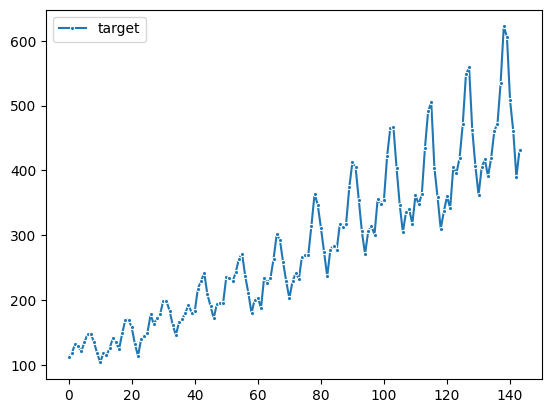

In [2]:
dataset = sm.datasets.get_rdataset('AirPassengers')
df = dataset.data['value'].to_frame(name="target")
display(df.head())

fig, ax = plt.subplots()
sns.lineplot(df, marker='.')
plt.show()

df_train = df.iloc[:-10]
df_test = df.iloc[-10:]

モデリング

In [3]:
# p=1, d=0, q=1, P=1, D=0, Q=1で考える
results = SARIMAX(df_train["target"], order=(1,0,1), seasonal_order=(1,0,1,12),
                            enforce_stationarity = False, enforce_invertibility = False
                           ).fit()

In [4]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             target   No. Observations:                  134
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -435.404
Date:                            Wed, 13 Mar 2024   AIC                            880.807
Time:                                    14:47:28   BIC                            894.745
Sample:                                         0   HQIC                           886.467
                                            - 134                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9154      0.052     17.575      0.000       0.813       1.017
ma.L1         -0.2901      0.084     -3.463      0.001      -0.454      -0.126
ar.S.L12       1.1267      0.011    105.153      0.000       1.106       1.148
ma.S.L12      -0.4638      0.114     -4.061      0.000      -0.688      -0.240
sigma2        80.9550     10.266      7.886      0.000      60.835     101.075
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 9.32
Prob(Q):                              0.74   Prob(JB):                         0.01
Heteroskedasticity (H):               1.49   Skew:                            -0.40
Prob(H) (two-sided):                  0.21   Kurtosis:                         4.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

予測

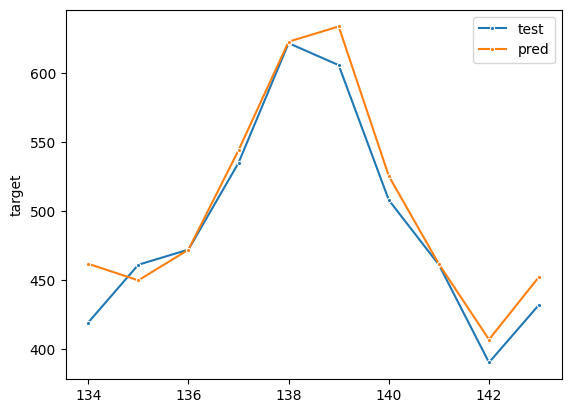

In [5]:
forecast = results.get_forecast(steps=10)
y_pred = forecast.predicted_mean # 各時点の期待値を予測とする

fig, ax = plt.subplots()
#sns.lineplot(df_train["target"], label="train", marker='.')
sns.lineplot(df_test["target"], label="test", marker='.')
sns.lineplot(y_pred, label="pred", marker='.')
plt.show()

In [6]:
display(forecast.predicted_mean) # 各時点の期待値
display(forecast.var_pred_mean) # 各時点の分散

134   461.72502
135   449.64672
136   471.94628
137   544.17055
138   623.04109
139   634.10196
140   525.44412
141   461.46805
142   406.66490
143   452.28110
Name: predicted_mean, dtype: float64

134    80.95502
135   112.60410
136   139.12466
137   161.34776
138   179.96976
139   195.57419
140   208.65003
141   219.60703
142   228.78852
143   236.48221
Name: var_pred_mean, dtype: float64

### 予測値の総和の**予測区間**を求める
  - 作ったモデルでN時点先までを予測する行為を複数回シミュレーションし、シミュレーション結果から各時点までの総和の予測区間を求める
  - SARIMAXのsimulateメソッドを使ってシミュレーションできそう(https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.simulate.html)
  - 予測区間の求め方(https://ja.wikipedia.org/wiki/%E4%BA%88%E6%B8%AC%E5%8C%BA%E9%96%93)


In [7]:
# def simulation_of_confidence_intervals(results, nsimulations, repetitions, anchor):
#     """モデリング結果からシミュレーションにより予測値の総和の95%予測区間を求める

#     Args:
#         results (SARIMAXResults): SARIMAXの返り値
#         nsimulations (int): 何時点先まで予測をするか
#         repetitions (int): シミュレーションの実行回数
#         anchor (int): シミュレーションの開始時刻

#     Returns:
#         y (list): 時点hまでの予測値の総和の期待値
#         ci_upper (list): 信頼区間の上限
#         ci_lower (list): 信頼区間の下限
#     """

#     forecast = results.get_forecast(steps=nsimulations)
#     y_pred = forecast.predicted_mean # 予測値を求める
#     simulated_obs = results.simulate(nsimulations=nsimulations, repetitions=repetitions, anchor=anchor) # 推定したパラメータを用いて予測のシミュレーションをする

#     y, ci_upper, ci_lower = [], [], [] # 時点hまでの予測値の総和の期待値、信頼区間の上限、信頼区間の下限
#     for h in range(1, nsimulations+1):
#         simulated_obs_part = simulated_obs.iloc[:h] # 時点hまでの予測値のシミュレーションを取り出す
#         #mean_bar = simulated_obs_part. # h期先までの予測の総和が従う正規分布の期待値
#         y_pred_sum = y_pred[:h].sum() # h期先までの総和をとったものは、正規分布に従い期待値はh期先までの予測値の総和になる
#         y.append(y_pred_sum)
#         std_value = simulated_obs_part.sum(axis=0).std() # シミュレーションを使ってh期先までの総和の標準偏差を求める
#         ci_upper.append(y_pred_sum + 1.96*std_value) # 信頼区間を求める
#         ci_lower.append(y_pred_sum - 1.96*std_value)
#     return y, ci_upper, ci_lower


# nsimulations = 10 # 何時点先まで予測をするか
# repetitions = 10000 # シミュレーションを何回実行するか
# anchor = len(df_train) # シミュレーションの開始時刻(trainの1期先にしたい)

# # 結果のプロット
# y, ci_upper, ci_lower = simulation_of_confidence_intervals(results, nsimulations, repetitions, anchor)
# x = list(range(len(df_train), len(df_train)+nsimulations))
# fig, ax = plt.subplots()
# ax.plot(x, y, marker=".")
# ax.fill_between(x, ci_upper, ci_lower, color='b', alpha=.1)
# plt.show()

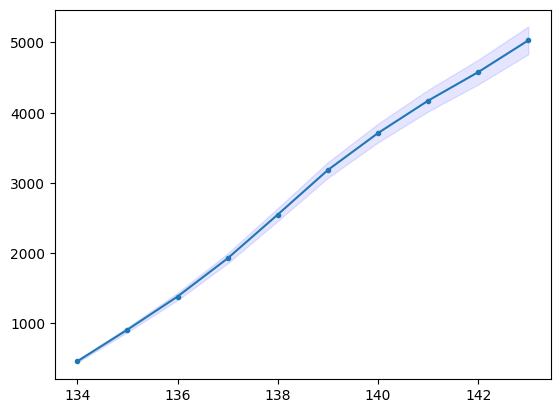

In [8]:
def calculate_prediction_interval(simulated_obs_part, n, p):
    """サンプリングしたデータからp%予測区間を求める

    Args:
        simulated_obs_part (DataFrame): (時点数, シミュレーション回数)のサンプルを入れたDataFrame
        n (int): サンプルサイズ(シミュレーション回数)
        p (float): p%予測区間を求める時のp

    Returns:
        mean_bar (float): 時点hまでの予測値の総和の標本平均
        ci_upper (float): p%予測区間の上限
        ci_lower (float): p%予測区間の下限
    """
    mean_bar = simulated_obs_part.sum(axis=0).mean() # 標本平均を求める
    sn = np.sqrt(np.sum((simulated_obs_part.sum(axis=0) - mean_bar)**2) / (n-1)) # 標準偏差を求める
    ta = t.ppf((1+p)/2, n-1)
    ci = ta*sn*np.sqrt(1+(1/n))
    ci_upper = mean_bar+ci
    ci_lower = mean_bar-ci
    return mean_bar, ci_upper, ci_lower

def simulation_of_prediction_intervals(results, nsimulations, repetitions, anchor, p):
    """モデリング結果からシミュレーションにより予測値の総和の予測区間を求める

    Args:
        results (SARIMAXResults): SARIMAXの返り値
        nsimulations (int): 何時点先まで予測をするか
        repetitions (int): シミュレーションの実行回数
        anchor (int): シミュレーションの開始時刻
        p (float): p%予測区間を求める時のp

    Returns:
        mean_bars (list): 時点hまでの予測値の総和の期待値
        ci_uppers (list): 予測区間の上限
        ci_lowers (list): 予測区間の下限
    """

    forecast = results.get_forecast(steps=nsimulations)
    y_pred = forecast.predicted_mean # 予測値を求める
    simulated_obs = results.simulate(nsimulations=nsimulations, repetitions=repetitions, anchor=anchor) # 推定したパラメータを用いて予測のシミュレーションをする

    mean_bars, ci_uppers, ci_lowers = [], [], [] # 時点hまでの予測値の総和の期待値、予測区間の上限、予測区間の下限
    for h in range(1, nsimulations+1):
        simulated_obs_part = simulated_obs.iloc[:h] # 時点hまでの予測値のシミュレーションを取り出す
        mean_bar, ci_upper, ci_lower, = calculate_prediction_interval(simulated_obs_part, repetitions, p) # 時点hまでの予測値の総和の予測区間を求める
        mean_bars.append(mean_bar)
        ci_uppers.append(ci_upper)
        ci_lowers.append(ci_lower)
    return mean_bars, ci_uppers, ci_lowers


nsimulations = 10 # 何時点先まで予測をするか
repetitions = 10000 # シミュレーションを何回実行するか
anchor = len(df_train) # シミュレーションの開始時刻(trainの1期先にしたい)
p = 0.95

# 結果のプロット
y, ci_upper, ci_lower = simulation_of_prediction_intervals(results, nsimulations, repetitions, anchor, p)
x = list(range(len(df_train), len(df_train)+nsimulations))
fig, ax = plt.subplots()
ax.plot(x, y, marker=".")
ax.fill_between(x, ci_upper, ci_lower, color='b', alpha=.1)
plt.show()


### conf_intが何をしているのかを探る
- 沖本本に載ってる区間予測の導出と比較する
- ぱっと見同じ？conf_int=区間予測か？

,lower target,upper target
134,444.09024,479.35980
135,428.84855,470.44490
136,448.82829,495.06427
137,519.27456,569.06655
138,596.74763,649.33456
139,606.69228,661.51163
140,497.13299,553.75526
141,432.42306,490.51304
142,377.01896,436.31083
143,422.14081,482.42138


,lower target,upper target
0,443.82259,479.62745
1,428.71141,470.58204
2,448.78217,495.11039
3,519.23666,569.10445
4,596.71788,649.36431
5,606.51853,661.68538
6,497.10503,553.78322
7,432.23740,490.69870
8,376.90168,436.42812
9,422.23384,482.32835


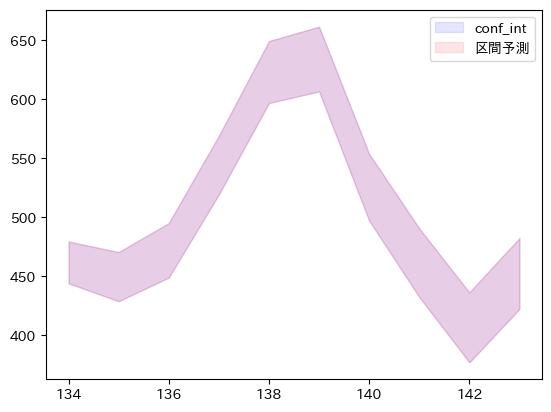

In [27]:
# まずconf_intをやってみる
forecast = results.get_forecast(steps=nsimulations)
y_pred = forecast.predicted_mean # 予測値を求める
simulated_obs = results.simulate(nsimulations=nsimulations, repetitions=repetitions, anchor=anchor) # 推定したパラメータを用いて予測のシミュレーションをする
conf_int_pred = forecast.conf_int(alpha=0.05)

# 沖本本3.3節に載ってる区間予測を再現する
mse = ((y_pred.to_numpy().reshape(10, -1) - simulated_obs.to_numpy())**2).mean(axis=1) # p67(5)、予測値とシミュレーションから各時点のMSE(標準偏差)を求める
ci = 1.96*np.sqrt(mse)
okimoto_pred = pd.DataFrame(np.array([y_pred-ci, y_pred+ci]).T, columns=["lower target", "upper target"])

# 結果のプロット
display(conf_int_pred)
display(okimoto_pred)
fig, ax = plt.subplots()
ax.fill_between(x, conf_int_pred["upper target"], conf_int_pred["lower target"], color='b', alpha=.1, label="conf_int")
ax.fill_between(x, okimoto_pred["upper target"], okimoto_pred["lower target"], color='r', alpha=.1, label="区間予測")
plt.legend();plt.show()

予測値の総和の**区間予測**をブートストラップで求める
- https://otexts.com/fppjp/aggregates.html
- 非線形最小二乗法を使ったモデルでも、誤差項を正規分布と考えているならシミュレーションから平均と標準偏差を求めて興味のある区間を求めれば良い？

In [40]:
h = 10 # 時点hまでの予測値の総和について知りたい

simulated_obs = results.simulate(nsimulations=nsimulations, repetitions=repetitions, anchor=anchor) # 推定したパラメータを用いて予測のシミュレーションをする
simulated_obs_sum = simulated_obs.iloc[:h].sum(axis=0)
# print(np.percentile(simulated_obs_sum, 50))
# print(np.percentile(simulated_obs_sum, 5))
# print(np.percentile(simulated_obs_sum, 95))

simulated_obs_mean = simulated_obs_sum.mean()
simulated_obs_std = simulated_obs_sum.std()
print(simulated_obs_mean)
print(simulated_obs_mean - 1.96*simulated_obs_std)
print(simulated_obs_mean + 1.96*simulated_obs_std)

5030.641071112658
4836.218018054535
5225.064124170782
